In [1]:
import torch
from models import BCDnet
import numpy as np

from utils import od2rgb, rgb2od, direct_deconvolution
import matplotlib.pyplot as plt

from datasets import WSSBDatasetTest

In [2]:
weights_dict = torch.load('/work/work_fran/Deep_Var_BCD/weights/best_weights_icip/best.pt')

In [3]:
model = BCDnet(cnet_name='unet_64_6', mnet_name='mobilenetv3s_50')
model.load_state_dict(weights_dict)

<All keys matched successfully>

In [4]:
dataset = WSSBDatasetTest('/data/datasets/Alsubaie/Data/', organ_list=['Colon'], load_at_init=False)

[WSSBDataset] Scanning files...
[WSSBDataset] Done scanning files


In [5]:
img, M_gt = dataset[3]
img_np = img.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')
img_od = rgb2od(img)
M_mean, M_var, C_mean = model(img_od.unsqueeze(0)) # (1, 3, 2), (1, 1, 2), (1, 2, 224, 224)
M_mean = M_mean.detach().cpu()
M_var = M_var.detach().cpu()
C_mean = C_mean.detach().cpu()

In [6]:
img_rec_od = torch.einsum('bcs,bshw->bchw', M_mean, C_mean) # (1, 3, 224, 224)
img_rec = torch.clamp(od2rgb(img_rec_od), 0.0, 255.0)
img_rec_np = img_rec.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')

C_gt = direct_deconvolution(img_od, M_gt)
M_gt = M_gt.unsqueeze(0) # (1, 3, 2)
C_gt = C_gt.unsqueeze(0) # (1, 2, 224, 224)

M_gt_rgb = torch.clamp(od2rgb(M_gt / np.log(256)), 0.0, 255.0) # (1, 3, 2)
M_gt_rgb_np = M_gt_rgb.squeeze().detach().cpu().numpy().transpose(1, 0).astype('int') # (2, 3)

C_H_gt_od = C_gt[:, 0, :, :].squeeze() # (224, 224)
C_H_gt = torch.clamp(od2rgb(C_H_gt_od), 0.0, 255.0)
C_H_gt_np = C_gt[:, 0, :, :].squeeze().numpy() # (224, 224)

C_E_gt_od = C_gt[:, 1, :, :].squeeze() # (224, 224)
C_E_gt = torch.clamp(od2rgb(C_E_gt_od), 0.0, 255.0)
C_E_gt_np = C_gt[:, 1, :, :].squeeze().numpy() # (224, 224)

H_gt_od = torch.einsum('bcs,bshw->bschw', M_gt, C_gt)[:,0,:,:] # (batch_size, H, W)
H_gt = torch.clamp(od2rgb(H_gt_od), 0.0, 255.0) # (batch_size, 3, H, W)
E_gt_od = torch.einsum('bcs,bshw->bschw', M_gt, C_gt)[:,1,:,:] # (batch_size, H, W)
E_gt = torch.clamp(od2rgb(E_gt_od), 0.0, 255.0) # (batch_size, 3, H, W)

H_gt_np = H_gt.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')
E_gt_np = E_gt.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')


M_rec_rgb = torch.clamp(od2rgb(M_mean / np.log(256)), 0.0, 255.0) # (1, 3, 2)
M_rec_rgb_np = M_rec_rgb.squeeze().detach().cpu().numpy().transpose(1, 0).astype('int') # (2, 3)

C_H_rec_od = C_mean[:, 0, :, :].squeeze() # (224, 224)
C_H_rec = torch.clamp(od2rgb(C_H_rec_od), 0.0, 255.0)
C_H_rec_np = C_mean[:, 0, :, :].squeeze().numpy() # (224, 224)

C_E_rec_od = C_mean[:, 1, :, :].squeeze() # (224, 224)
C_E_rec = torch.clamp(od2rgb(C_E_rec_od), 0.0, 255.0)
C_E_rec_np = C_mean[:, 1, :, :].squeeze().numpy() # (224, 224)

H_rec_od = torch.einsum('bcs,bshw->bschw', M_mean, C_mean)[:,0,:,:] # (batch_size, H, W)
H_rec = torch.clamp(od2rgb(H_rec_od), 0.0, 255.0) # (batch_size, 3, H, W)
E_rec_od = torch.einsum('bcs,bshw->bschw', M_mean, C_mean)[:,1,:,:] # (batch_size, H, W)
E_rec = torch.clamp(od2rgb(E_rec_od), 0.0, 255.0) # (batch_size, 3, H, W)

H_rec_np = H_rec.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')
E_rec_np = E_rec.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')

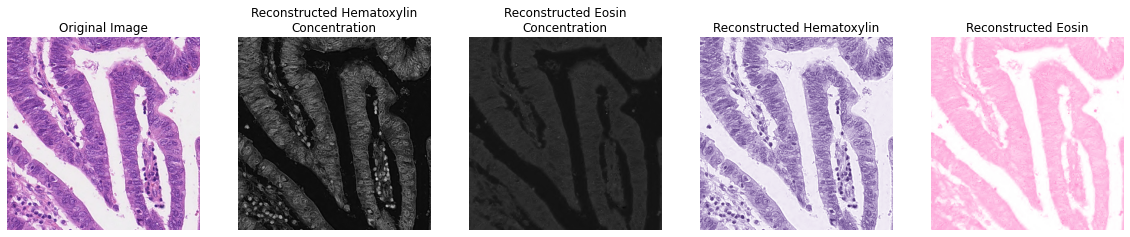

In [19]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

ax[0].imshow(img_np)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(C_H_rec_np, cmap='gray')
ax[1].set_title('Reconstructed Hematoxylin\nConcentration')
ax[1].axis('off')

ax[2].imshow(C_E_rec_np, cmap='gray')
ax[2].set_title('Reconstructed Eosin\nConcentration')
ax[2].axis('off')

ax[3].imshow(H_rec_np)
ax[3].set_title('Reconstructed Hematoxylin')
ax[3].axis('off')

ax[4].imshow(E_rec_np)
ax[4].set_title('Reconstructed Eosin')
ax[4].axis('off')

fig.savefig('demonstration.png', bbox_inches='tight')

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(18, 8))

ax[0,0].imshow(np.expand_dims(M_gt_rgb_np, axis=0))
ax[0,0].set_title('Original M')
ax[0,0].axis('off')

ax[0,1].imshow(img_np)
ax[0,1].set_title('Original Image')
ax[0,1].axis('off')

ax[0,2].imshow(C_H_gt_np, cmap='gray')
ax[0,2].set_title('Original Hematoxylin\nConcentration')
ax[0,2].axis('off')

ax[0,3].imshow(C_E_gt_np, cmap='gray')
ax[0,3].set_title('Original Eosin\nConcentration')
ax[0,3].axis('off')

ax[0,4].imshow(H_gt_np)
ax[0,4].set_title('Original Hematoxylin')
ax[0,4].axis('off')

ax[0,5].imshow(E_gt_np)
ax[0,5].set_title('Original Eosin')
ax[0,5].axis('off')

ax[1,0].imshow(np.expand_dims(M_rec_rgb_np, axis=0))
ax[1,0].set_title('Reconstructed M')
ax[1,0].axis('off')

ax[1,1].imshow(img_rec_np)
ax[1,1].set_title('Reconstructed Image')
ax[1,1].axis('off')

ax[1,2].imshow(C_H_rec_np, cmap='gray')
ax[1,2].set_title('Reconstructed Hematoxylin\nConcentration')
ax[1,2].axis('off')

ax[1,3].imshow(C_E_rec_np, cmap='gray')
ax[1,3].set_title('Reconstructed Eosin\nConcentration')
ax[1,3].axis('off')

ax[1,4].imshow(H_rec_np)
ax[1,4].set_title('Reconstructed Hematoxylin')
ax[1,4].axis('off')

ax[1,5].imshow(E_rec_np)
ax[1,5].set_title('Reconstructed Eosin')
ax[1,5].axis('off')

fig.savefig('inspect.png', bbox_inches='tight')


plt.tight_layout()
plt.show()
